In [2]:
#!pip install opencv-contrib-python
!pip install imutils
#!pip install scikit-learn
#!pip install tqdm

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=1fa1afb904251bae4f5ffc3e1b0d996f70acdf7291918eaaa61334320c13a0e7
  Stored in directory: /root/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import torch
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
import torchvision
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import time
import numpy as np
import random
from os.path import exists



plt.ion()   # interactive mode

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(rotation=45, ha='right', rotation_mode='anchor')

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

    plt.savefig(os.path.join(dir_prefix, 'ForestSegmentationOutput', 'CFMs', f"{title}.jpg"))

In [5]:
dir_prefix = '/data'

In [6]:
# base path of the dataset
DATASET_PATH = os.path.join(dir_prefix, 'ForestDataset8C')
TRAIN_DATASET_NAME = 'nks'
TEST_DATASET_NAME = 'train_polygons'
# define the path to the images and masks dataset
#IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "wv2_0")
#MASK_DATASET_PATH = os.path.join(DATASET_PATH, "nks")
# define the test split
TEST_SPLIT = 0.2
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 8
NUM_CLASSES = 13

# UNET layers
ENC_CHANNELS = (NUM_CHANNELS, 16, 32, 64, 128)
DEC_CHANNELS = (128, 64, 32, 16)
# WHether to train and test just on nks or to train on nks and test on train_polygons
TEST_TRAIN_SAME_DATASET = False
#For nks, 3% smnoothing, background class manually set to 0.55
CLASS_WEIGHTS = torch.tensor(
                [0.55962825,
                 1.23985772,
                 1.08779277,
                 2.61466572,
                 0.98158784,
                 3.61027868,
                 3.2204647,
                 0.68544988,
                 2.89362751,
                 1.46009199,
                 2.32775901,
                 2.79981566,
                 0],
                 dtype=torch.float
                )
# For train_polygons, smoothing all class's weights by adding 0.5% of np.sum(counts) of every class, disregarding background class: True, bacground class weight decreased
# CLASS_WEIGHTS = torch.tensor(
#                 [0.71699578,
#                  0.86965024,
#                  0.83796998,
#                  1.40117822,
#                  0.64571334,
#                  1.31878831,
#                  1.25086646,
#                  0.45417005,
#                  0.96135848,
#                  1.01883446,
#                  1.35632342,
#                  1.35991466,
#                  1.61584644],
#                  dtype=torch.float
#                 )
# For train_polygons, smoothing all class's weights by adding 0.1% of np.sum(counts) of every class, disregarding background class: True, bacground class weight decreased, 0 mannually set to 0.2
# CLASS_WEIGHTS = torch.tensor(
#                 [0.2,
#                  0.84980866,
#                  0.80220355,
#                  2.10060009,
#                  0.55026213,
#                  1.82590034,
#                  1.62915876,
#                  0.34886069,
#                  0.99946672,
#                  1.10342015,
#                  1.94564972,
#                  1.95756166,
#                  3.08878289],
#                  dtype=torch.float
#                 )
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 70
BATCH_SIZE = 8
# define the input image dimensions
INPUT_IMAGE_WIDTH = 512 # The images will be resized to this before getting fed into the model
INPUT_IMAGE_HEIGHT = 512 # The images will be resized to this before getting fed into the model
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = os.path.join(dir_prefix, 'ForestSegmentationOutput')
# define the path to the output serialized model, model training
# plot, and testing image paths
PRETRAINED_MODEL_NAME = '3percent_smoothly_weighted_more_complex_unet_nks_13_class_forest_59+11_epoch_0.001_lr_0.0001_wd.pth'
PRETRAINED_MODEL_PATH = os.path.join(BASE_OUTPUT, PRETRAINED_MODEL_NAME)
_output_model_name = f"3percent_smoothly_weighted_0_weight_0.55_more_complex_unet_{TRAIN_DATASET_NAME}_{NUM_CLASSES}_class_forest_59+11+{NUM_EPOCHS}_epoch_{INIT_LR}_lr_{WEIGHT_DECAY}_wd"
OUTPUT_MODEL_PATH = os.path.join(BASE_OUTPUT, f"{_output_model_name}.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, f"loss_{_output_model_name}.png"])
#TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

DEVICE: cuda


In [7]:
class ForestSegmentationDataset(Dataset):
    def __init__(self,
                 channels, # list so it defines order of cjannels since dict doesnt
                 imagePaths,
                 maskPaths,
                 transforms_img,
                 transforms_mask):
        # store the image and mask filepaths, and augmentation
        # transforms
        num_of_imgs = len(list(imagePaths.values())[0])
        for cname in channels:
            assert (cname in imagePaths) and (len(imagePaths[cname]) == num_of_imgs),'image paths for different channels of different length OR channel not present in imagePaths dict!!!'
            for imgpath in imagePaths[cname]:
                assert exists(imgpath), f"{imgpath} does not exist!"

        for mpath in maskPaths:
            assert exists(mpath), f"{mpath} does not exist!"

        self.channels = channels
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms_img = transforms_img
        self.transforms_mask = transforms_mask

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(list(self.imagePaths.values())[0])

    def __getitem__(self, idx):
        channels_to_stack = [
            cv2.imread(
                self.imagePaths[cname][idx],
                cv2.IMREAD_UNCHANGED
            ) for cname in self.channels
        ]
        image = np.stack(channels_to_stack) # This adds extra dimension at the beginning investigate if this does anything weird
        image = torch.tensor(np.float32(image / 255.0))
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_UNCHANGED)
        mask[mask < 0] = 0 # Background class should be zero not -3.4e+38
        mask = np.float32(mask)
        # check to see if we are applying any transformations
        # apply the transformations to both image and its mask
        if self.transforms_img is not None:
          image = self.transforms_img(image)

        if self.transforms_mask is not None:
          mask = self.transforms_mask(mask)
          mask = mask.to(torch.long).squeeze()
        # return a tuple of the image and its mask
        return (image, mask)

In [8]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)

    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
    def __init__(self, channels=ENC_CHANNELS):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
          [Block(channels[i], channels[i + 1])
            for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

class Decoder(Module):
    def __init__(self, channels=DEC_CHANNELS):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
          [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
            for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
          [Block(channels[i], channels[i + 1])
            for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

class UNet(Module):
    def __init__(self, encChannels=ENC_CHANNELS,
        decChannels=DEC_CHANNELS,
        nbClasses=NUM_CLASSES, retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
          encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [9]:
def slice_coords(path):
		path_no_ext = os.path.splitext(path)[0]
		coords = os.path.basename(path_no_ext).split('_')[-2:]
		return tuple([int(x) for x in coords])


def filter_data_present_in_other_set(Imgs, masks, slices_to_filter_out):
		slices_to_filter_out = set([slice_coords(path) for path in slices_to_filter_out])
		for k in Imgs:
				paths_to_keep = [path for path in Imgs[k] if slice_coords(path) not in slices_to_filter_out]
				Imgs[k] = paths_to_keep

		paths_to_keep = [path for path in masks if slice_coords(path) not in slices_to_filter_out]
		masks = paths_to_keep

		return Imgs, masks

## NEW WAY
def load_img_and_mask_paths(mask_version='nks', single_set=False):
		wv2_0_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_0-{mask_version}.csv')
		wv2_1_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_1-{mask_version}.csv')
		wv2_2_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_2-{mask_version}.csv')
		wv2_3_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_3-{mask_version}.csv')
		wv2_4_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_4-{mask_version}.csv')
		wv2_5_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_5-{mask_version}.csv')
		wv2_6_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_6-{mask_version}.csv')
		wv2_7_nks_data = pd.read_csv(f'/data/ForestDataset8C/Dataset-wv2_7-{mask_version}.csv')
		image0Paths = list(sorted(wv2_0_nks_data.imgPath))
		image1Paths = list(sorted(wv2_1_nks_data.imgPath))
		image2Paths = list(sorted(wv2_2_nks_data.imgPath))
		image3Paths = list(sorted(wv2_3_nks_data.imgPath))
		image4Paths = list(sorted(wv2_4_nks_data.imgPath))
		image5Paths = list(sorted(wv2_5_nks_data.imgPath))
		image6Paths = list(sorted(wv2_6_nks_data.imgPath))
		image7Paths = list(sorted(wv2_7_nks_data.imgPath))
		maskPaths = list(sorted(wv2_7_nks_data.maskPath))

		l = [image0Paths,
				 image1Paths,
				 image2Paths,
				 image3Paths,
				 image4Paths,
				 image5Paths,
				 image6Paths,
				 image7Paths,
				 maskPaths]
		for dataset in l:
				assert len(l[0]) == len(dataset), "List of paths of diffrenet length for differen channels/mask"
		for i in range(len(image0Paths)):
				assert all([slice_coords(image0Paths[i]) == slice_coords(img_dataset[i]) for img_dataset in l]), "Slices out of order for different channels/mask of dataset"


		if single_set:
				Imgs = {
						0: image0Paths,
						1: image1Paths,
						2: image2Paths,
						3: image3Paths,
						4: image4Paths,
						5: image5Paths,
						6: image6Paths,
						7: image7Paths,
				}
				return Imgs, maskPaths

		split = train_test_split(image0Paths,
														image1Paths,
														image2Paths,
														image3Paths,
														image4Paths,
														image5Paths,
														image6Paths,
														image7Paths,
														maskPaths,
														test_size=TEST_SPLIT,
														random_state=42)

		(trainImages0, testImages0) = split[:2]
		(trainImages1, testImages1) = split[2:4]
		(trainImages2, testImages2) = split[4:6]
		(trainImages3, testImages3) = split[6:8]
		(trainImages4, testImages4) = split[8:10]
		(trainImages5, testImages5) = split[10:12]
		(trainImages6, testImages6) = split[12:14]
		(trainImages7, testImages7) = split[14:16]
		(trainMasks, testMasks) = split[16:]

		trainImages = {
				0: trainImages0,
				1: trainImages1,
				2: trainImages2,
				3: trainImages3,
				4: trainImages4,
				5: trainImages5,
				6: trainImages6,
				7: trainImages7,
		}

		testImages = {
				0: testImages0,
				1: testImages1,
				2: testImages2,
				3: testImages3,
				4: testImages4,
				5: testImages5,
				6: testImages6,
				7: testImages7,
		}

		return trainImages, testImages, trainMasks, testMasks

In [10]:
if TEST_TRAIN_SAME_DATASET:
		print(f"TEST_TRAIN_SAME_DATASET False: {TEST_TRAIN_SAME_DATASET}")
		trainImages, testImages, trainMasks, testMasks = load_img_and_mask_paths(mask_version=TRAIN_DATASET_NAME)
elif TRAIN_DATASET_NAME == 'train_polygons':
		print(f"TEST_TRAIN_SAME_DATASET False: {TEST_TRAIN_SAME_DATASET}, training on: {TRAIN_DATASET_NAME}")
		Images_train_dataset, Masks_train_dataset = load_img_and_mask_paths(mask_version=TRAIN_DATASET_NAME, single_set=True)
		Images_test_dataset, Masks_test_dataset = load_img_and_mask_paths(mask_version=TEST_DATASET_NAME, single_set=True)
		testImages, testMasks = filter_data_present_in_other_set(Images_test_dataset, Masks_test_dataset, Masks_train_dataset)
		trainImages, trainMasks = (Images_train_dataset, Masks_train_dataset)
elif TRAIN_DATASET_NAME == 'nks':
		print(f"TEST_TRAIN_SAME_DATASET False: {TEST_TRAIN_SAME_DATASET}, training on: {TRAIN_DATASET_NAME}")
		Images_train_dataset, Masks_train_dataset = load_img_and_mask_paths(mask_version=TRAIN_DATASET_NAME, single_set=True)
		Images_test_dataset, Masks_test_dataset = load_img_and_mask_paths(mask_version=TEST_DATASET_NAME, single_set=True)
		trainImages, trainMasks = filter_data_present_in_other_set(Images_train_dataset, Masks_train_dataset, Masks_test_dataset)
		testImages, testMasks = (Images_test_dataset, Masks_test_dataset)

# define transformations
img_transforms = transforms.Compose([
   # transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), antialias=True),
	 # transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
	  transforms.ToTensor()
])

#create the train and test datasets
trainDS = ForestSegmentationDataset(
		channels=list(np.arange(8)),
		imagePaths=trainImages,
		maskPaths=trainMasks,
		transforms_img=img_transforms,
		transforms_mask=mask_transforms
		)

testDS = ForestSegmentationDataset(
		channels=list(np.arange(8)),
		imagePaths=testImages,
		maskPaths=testMasks,
    transforms_img=img_transforms,
		transforms_mask=mask_transforms
		)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

TEST_TRAIN_SAME_DATASET False: False, training on: nks
[INFO] found 632 examples in the training set...
[INFO] found 96 examples in the test set...


In [11]:
len(trainDS)

632

In [12]:
len(testDS)

96

In [13]:
# initialize our UNet model
if PRETRAINED_MODEL_PATH:
    print(f"Loading pretrained model {PRETRAINED_MODEL_PATH}")
    unet = torch.load(PRETRAINED_MODEL_PATH).to(DEVICE)
else:
    print('Initializing new model from scratch')
    unet = UNet().to(DEVICE)


Loading pretrained model /data/ForestSegmentationOutput/3percent_smoothly_weighted_more_complex_unet_nks_13_class_forest_59+11_epoch_0.001_lr_0.0001_wd.pth


In [14]:
# initialize loss function and optimizer
lossFunc = CrossEntropyLoss(weight=CLASS_WEIGHTS.to(DEVICE))
opt = Adam(unet.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [15]:
!df -h

Filesystem                         Size  Used Avail Use% Mounted on
overlay                            915G  378G  498G  44% /
tmpfs                               64M     0   64M   0% /dev
tmpfs                               63G     0   63G   0% /sys/fs/cgroup
shm                                 10G     0   10G   0% /dev/shm
/dev/sda1                          3.6T  2.8T  615G  83% /data
/dev/mapper/ubuntu--vg-ubuntu--lv  915G  378G  498G  44% /etc/hosts
tmpfs                               63G   12K   63G   1% /proc/driver/nvidia
udev                                63G     0   63G   0% /dev/nvidia0
tmpfs                               63G     0   63G   0% /proc/asound
tmpfs                               63G     0   63G   0% /proc/acpi
tmpfs                               63G     0   63G   0% /proc/scsi
tmpfs                               63G     0   63G   0% /sys/firmware


  0%|          | 0/70 [00:00<?, ?it/s]

[INFO] training the network...


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|▏         | 1/70 [00:24<27:47, 24.17s/it]

[INFO] EPOCH: 1/70
Train loss: 1.590186, Test loss: 2.6499


  3%|▎         | 2/70 [00:39<21:29, 18.96s/it]

[INFO] EPOCH: 2/70
Train loss: 1.570670, Test loss: 2.6539


  4%|▍         | 3/70 [00:49<16:28, 14.75s/it]

[INFO] EPOCH: 3/70
Train loss: 1.574644, Test loss: 2.3997


  6%|▌         | 4/70 [00:59<14:05, 12.81s/it]

[INFO] EPOCH: 4/70
Train loss: 1.544775, Test loss: 2.4633


  7%|▋         | 5/70 [01:08<12:41, 11.71s/it]

[INFO] EPOCH: 5/70
Train loss: 1.550552, Test loss: 2.5439


  9%|▊         | 6/70 [01:18<11:49, 11.08s/it]

[INFO] EPOCH: 6/70
Train loss: 1.562369, Test loss: 2.5306


 10%|█         | 7/70 [01:28<11:11, 10.66s/it]

[INFO] EPOCH: 7/70
Train loss: 1.556269, Test loss: 2.6771


 11%|█▏        | 8/70 [01:38<10:47, 10.45s/it]

[INFO] EPOCH: 8/70
Train loss: 1.533001, Test loss: 2.3908


 13%|█▎        | 9/70 [01:48<10:24, 10.24s/it]

[INFO] EPOCH: 9/70
Train loss: 1.562919, Test loss: 2.5486


 14%|█▍        | 10/70 [01:58<10:07, 10.13s/it]

[INFO] EPOCH: 10/70
Train loss: 1.553504, Test loss: 2.4033


 16%|█▌        | 11/70 [02:08<09:52, 10.05s/it]

[INFO] EPOCH: 11/70
Train loss: 1.540599, Test loss: 2.6446


 17%|█▋        | 12/70 [02:17<09:38,  9.97s/it]

[INFO] EPOCH: 12/70
Train loss: 1.547948, Test loss: 2.4643


 19%|█▊        | 13/70 [02:27<09:25,  9.93s/it]

[INFO] EPOCH: 13/70
Train loss: 1.574036, Test loss: 2.4998


 20%|██        | 14/70 [02:37<09:15,  9.93s/it]

[INFO] EPOCH: 14/70
Train loss: 1.533906, Test loss: 2.4371


 21%|██▏       | 15/70 [02:47<09:05,  9.92s/it]

[INFO] EPOCH: 15/70
Train loss: 1.549390, Test loss: 2.5170


 23%|██▎       | 16/70 [02:57<08:56,  9.93s/it]

[INFO] EPOCH: 16/70
Train loss: 1.531914, Test loss: 2.4393


 24%|██▍       | 17/70 [03:07<08:44,  9.89s/it]

[INFO] EPOCH: 17/70
Train loss: 1.521613, Test loss: 2.3932


 26%|██▌       | 18/70 [03:17<08:34,  9.90s/it]

[INFO] EPOCH: 18/70
Train loss: 1.517628, Test loss: 2.4895


 27%|██▋       | 19/70 [03:26<08:24,  9.89s/it]

[INFO] EPOCH: 19/70
Train loss: 1.575592, Test loss: 2.4539


 29%|██▊       | 20/70 [03:36<08:13,  9.86s/it]

[INFO] EPOCH: 20/70
Train loss: 1.553335, Test loss: 2.4175


 30%|███       | 21/70 [03:46<08:04,  9.90s/it]

[INFO] EPOCH: 21/70
Train loss: 1.553603, Test loss: 2.3814


 31%|███▏      | 22/70 [03:56<07:56,  9.93s/it]

[INFO] EPOCH: 22/70
Train loss: 1.531433, Test loss: 2.3920


 33%|███▎      | 23/70 [04:06<07:47,  9.94s/it]

[INFO] EPOCH: 23/70
Train loss: 1.562115, Test loss: 2.3355


 34%|███▍      | 24/70 [04:16<07:38,  9.97s/it]

[INFO] EPOCH: 24/70
Train loss: 1.532039, Test loss: 2.5130


 36%|███▌      | 25/70 [04:26<07:27,  9.94s/it]

[INFO] EPOCH: 25/70
Train loss: 1.532796, Test loss: 2.3751


 37%|███▋      | 26/70 [04:36<07:16,  9.91s/it]

[INFO] EPOCH: 26/70
Train loss: 1.526316, Test loss: 2.3930


 39%|███▊      | 27/70 [04:46<07:05,  9.89s/it]

[INFO] EPOCH: 27/70
Train loss: 1.532476, Test loss: 2.3855


 40%|████      | 28/70 [04:56<06:56,  9.92s/it]

[INFO] EPOCH: 28/70
Train loss: 1.513248, Test loss: 2.5131


 41%|████▏     | 29/70 [05:06<06:48,  9.96s/it]

[INFO] EPOCH: 29/70
Train loss: 1.517570, Test loss: 2.4442


 43%|████▎     | 30/70 [05:16<06:38,  9.97s/it]

[INFO] EPOCH: 30/70
Train loss: 1.500381, Test loss: 2.5100


 44%|████▍     | 31/70 [05:26<06:29,  9.99s/it]

[INFO] EPOCH: 31/70
Train loss: 1.524652, Test loss: 2.4445


 46%|████▌     | 32/70 [05:36<06:19,  9.98s/it]

[INFO] EPOCH: 32/70
Train loss: 1.521792, Test loss: 2.3051


 47%|████▋     | 33/70 [05:46<06:09,  9.98s/it]

[INFO] EPOCH: 33/70
Train loss: 1.533418, Test loss: 2.4929


 49%|████▊     | 34/70 [05:56<05:59,  9.97s/it]

[INFO] EPOCH: 34/70
Train loss: 1.518740, Test loss: 2.3525


 50%|█████     | 35/70 [06:06<05:48,  9.97s/it]

[INFO] EPOCH: 35/70
Train loss: 1.512586, Test loss: 2.5924


 51%|█████▏    | 36/70 [06:16<05:38,  9.95s/it]

[INFO] EPOCH: 36/70
Train loss: 1.499559, Test loss: 2.5424


 53%|█████▎    | 37/70 [06:26<05:27,  9.94s/it]

[INFO] EPOCH: 37/70
Train loss: 1.501686, Test loss: 2.3753


 54%|█████▍    | 38/70 [06:36<05:18,  9.94s/it]

[INFO] EPOCH: 38/70
Train loss: 1.503172, Test loss: 2.4796


 56%|█████▌    | 39/70 [06:45<05:08,  9.95s/it]

[INFO] EPOCH: 39/70
Train loss: 1.488281, Test loss: 2.5262


 57%|█████▋    | 40/70 [06:55<04:58,  9.95s/it]

[INFO] EPOCH: 40/70
Train loss: 1.522769, Test loss: 2.4487


 59%|█████▊    | 41/70 [07:05<04:48,  9.96s/it]

[INFO] EPOCH: 41/70
Train loss: 1.527183, Test loss: 2.4189


 60%|██████    | 42/70 [07:15<04:37,  9.92s/it]

[INFO] EPOCH: 42/70
Train loss: 1.481777, Test loss: 2.4492


 61%|██████▏   | 43/70 [07:25<04:28,  9.94s/it]

[INFO] EPOCH: 43/70
Train loss: 1.502271, Test loss: 2.4502


 63%|██████▎   | 44/70 [07:35<04:17,  9.92s/it]

[INFO] EPOCH: 44/70
Train loss: 1.484215, Test loss: 2.5086


 64%|██████▍   | 45/70 [07:45<04:07,  9.92s/it]

[INFO] EPOCH: 45/70
Train loss: 1.491173, Test loss: 2.5272


 66%|██████▌   | 46/70 [07:55<03:57,  9.90s/it]

[INFO] EPOCH: 46/70
Train loss: 1.514836, Test loss: 2.3652


 67%|██████▋   | 47/70 [08:05<03:47,  9.89s/it]

[INFO] EPOCH: 47/70
Train loss: 1.502650, Test loss: 2.4364


 69%|██████▊   | 48/70 [08:15<03:37,  9.91s/it]

[INFO] EPOCH: 48/70
Train loss: 1.493733, Test loss: 2.4157


 70%|███████   | 49/70 [08:25<03:28,  9.92s/it]

[INFO] EPOCH: 49/70
Train loss: 1.474679, Test loss: 2.3499


 71%|███████▏  | 50/70 [08:35<03:18,  9.92s/it]

[INFO] EPOCH: 50/70
Train loss: 1.512975, Test loss: 2.4721


 73%|███████▎  | 51/70 [08:45<03:09,  9.97s/it]

[INFO] EPOCH: 51/70
Train loss: 1.483758, Test loss: 2.3699


 74%|███████▍  | 52/70 [08:55<03:00, 10.04s/it]

[INFO] EPOCH: 52/70
Train loss: 1.499701, Test loss: 2.3767


 76%|███████▌  | 53/70 [09:05<02:51, 10.07s/it]

[INFO] EPOCH: 53/70
Train loss: 1.484089, Test loss: 2.4967


 77%|███████▋  | 54/70 [09:15<02:41, 10.07s/it]

[INFO] EPOCH: 54/70
Train loss: 1.475868, Test loss: 2.4117


 79%|███████▊  | 55/70 [09:25<02:31, 10.07s/it]

[INFO] EPOCH: 55/70
Train loss: 1.484355, Test loss: 2.5377


 80%|████████  | 56/70 [09:35<02:21, 10.08s/it]

[INFO] EPOCH: 56/70
Train loss: 1.486967, Test loss: 2.4936


 81%|████████▏ | 57/70 [09:45<02:11, 10.10s/it]

[INFO] EPOCH: 57/70
Train loss: 1.460856, Test loss: 2.4385


 83%|████████▎ | 58/70 [09:56<02:01, 10.10s/it]

[INFO] EPOCH: 58/70
Train loss: 1.502018, Test loss: 2.4444


 84%|████████▍ | 59/70 [10:05<01:50, 10.03s/it]

[INFO] EPOCH: 59/70
Train loss: 1.471667, Test loss: 2.3503


 86%|████████▌ | 60/70 [10:15<01:39,  9.97s/it]

[INFO] EPOCH: 60/70
Train loss: 1.464844, Test loss: 2.4012


 87%|████████▋ | 61/70 [10:25<01:29,  9.93s/it]

[INFO] EPOCH: 61/70
Train loss: 1.519826, Test loss: 2.4867


 89%|████████▊ | 62/70 [10:35<01:19,  9.98s/it]

[INFO] EPOCH: 62/70
Train loss: 1.511864, Test loss: 2.4837


 90%|█████████ | 63/70 [10:45<01:09,  9.93s/it]

[INFO] EPOCH: 63/70
Train loss: 1.463058, Test loss: 2.4695


 91%|█████████▏| 64/70 [10:55<00:59,  9.93s/it]

[INFO] EPOCH: 64/70
Train loss: 1.473337, Test loss: 2.5072


 93%|█████████▎| 65/70 [11:05<00:49,  9.91s/it]

[INFO] EPOCH: 65/70
Train loss: 1.514221, Test loss: 2.4116


 94%|█████████▍| 66/70 [11:15<00:39,  9.90s/it]

[INFO] EPOCH: 66/70
Train loss: 1.497478, Test loss: 2.4587


 96%|█████████▌| 67/70 [11:25<00:29,  9.93s/it]

[INFO] EPOCH: 67/70
Train loss: 1.492980, Test loss: 2.6233


 97%|█████████▋| 68/70 [11:35<00:19,  9.96s/it]

[INFO] EPOCH: 68/70
Train loss: 1.489886, Test loss: 2.2842


 99%|█████████▊| 69/70 [11:45<00:09,  9.96s/it]

[INFO] EPOCH: 69/70
Train loss: 1.454868, Test loss: 2.5380


100%|██████████| 70/70 [11:54<00:00, 10.21s/it]

[INFO] EPOCH: 70/70
Train loss: 1.457370, Test loss: 2.4645
[INFO] total time taken to train the model: 714.99s


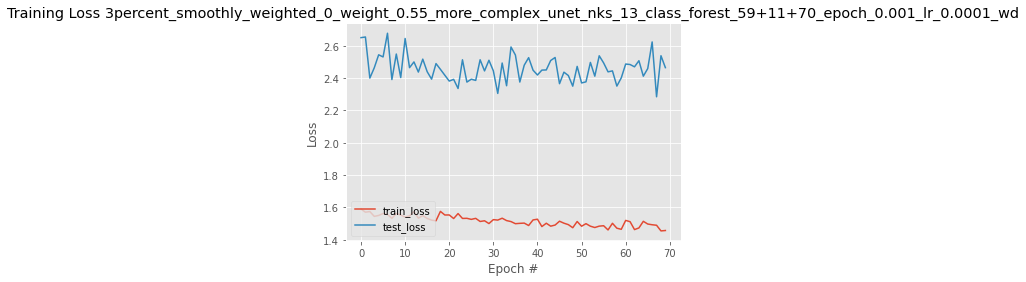

In [16]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
      # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        maximum_mask_vals = []
        minimum_mask_vals = []
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            minimum_mask_vals.append(int(pred.min()))
            maximum_mask_vals.append(int(pred.max()))
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    avgTrainLoss = avgTrainLoss.cpu().detach().item()
    avgTestLoss = avgTestLoss.cpu().detach().item()
    # Save model if best model so far
    if H['test_loss'] and avgTestLoss < min(H['test_loss']):
        torch.save(unet, OUTPUT_MODEL_PATH)
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
  endTime - startTime))


# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title(f"Training Loss {_output_model_name}")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
# torch.save(unet, OUTPUT_MODEL_PATH)
unet = torch.load(OUTPUT_MODEL_PATH).to(DEVICE)



In [17]:
OUTPUT_MODEL_PATH

'/data/ForestSegmentationOutput/3percent_smoothly_weighted_0_weight_0.55_more_complex_unet_nks_13_class_forest_59+11+70_epoch_0.001_lr_0.0001_wd.pth'

[INFO] load up 3percent_smoothly_weighted_0_weight_0.55_more_complex_unet_nks_13_class_forest_59+11+70_epoch_0.001_lr_0.0001_wd and testing on nks
predicted counts: (array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11]), array([  271931, 16554350, 58462619,  2955962, 31464875, 32992198,
        3668541, 20992720, 20843439,  2109909]))
ground_truth counts: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 8825114, 21552685, 29659142,  5230464, 33901442,   545771,
        2161609, 54155759,  3710859, 19510814,  7521982,  3540903]))
[INFO] load up 3percent_smoothly_weighted_0_weight_0.55_more_complex_unet_nks_13_class_forest_59+11+70_epoch_0.001_lr_0.0001_wd and testing on train_polygons
predicted counts: (array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11]), array([  11524, 1530833, 7512611,  380665, 4482814, 4854351, 1281133,
       2825001, 2142254,  144638]))
ground_truth counts: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([2781905, 2341592, 2343347,  6986

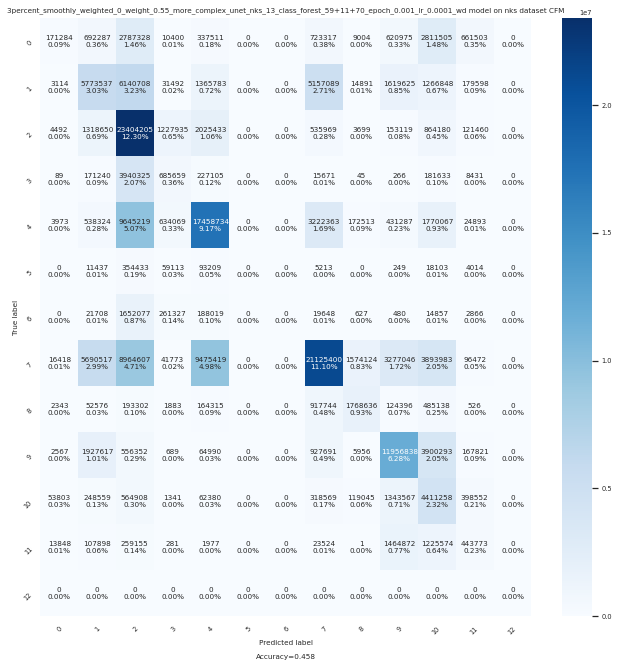

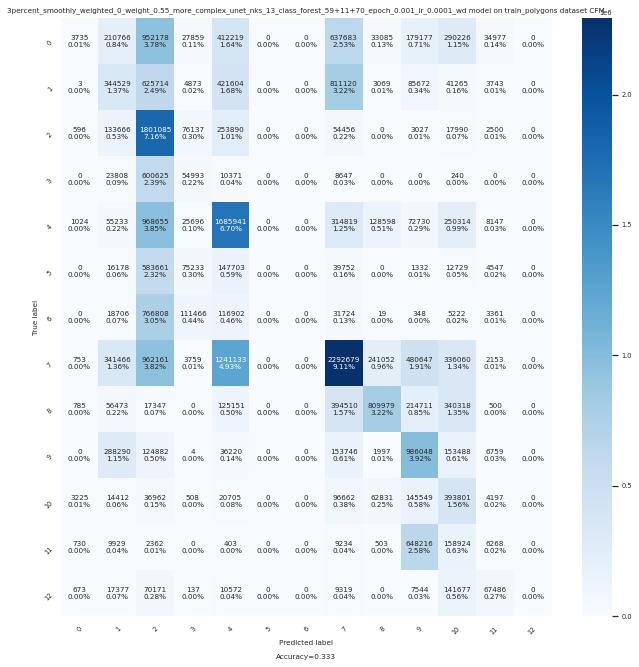

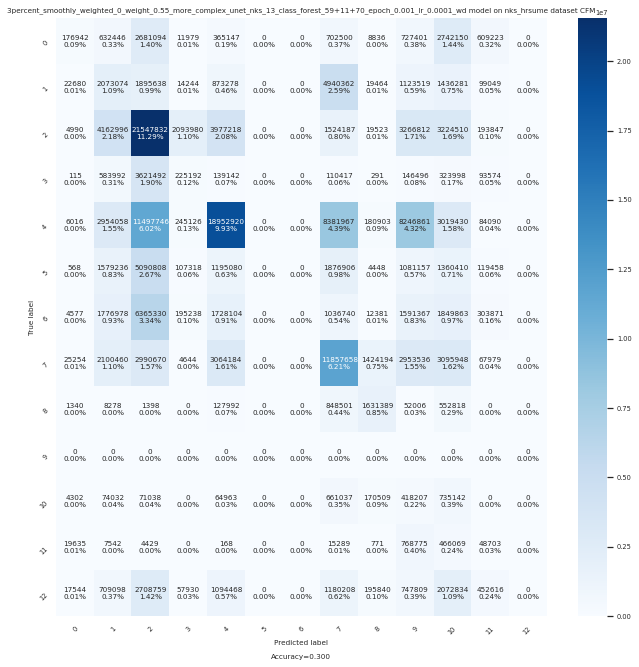

In [18]:
# Testing models on other daatsets
# define transformations
img_transforms = transforms.Compose([
   # transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), antialias=True),
	 # transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
	  transforms.ToTensor()
])

Images_nks, Masks_nks = load_img_and_mask_paths(mask_version='nks', single_set=True)
Images_nks_hrsume, Masks_nks_hrsume = load_img_and_mask_paths(mask_version='nks_hrsume', single_set=True)
Images_train_polygons, Masks_train_polygons = load_img_and_mask_paths(mask_version='train_polygons', single_set=True)


test_sets = {
    'nks': ForestSegmentationDataset(
              channels=list(np.arange(8)),
              imagePaths=Images_nks,
              maskPaths=Masks_nks,
              transforms_img=img_transforms,
              transforms_mask=mask_transforms
          ),
    'nks_hrsume': ForestSegmentationDataset(
                      channels=list(np.arange(8)),
                      imagePaths=Images_nks_hrsume,
                      maskPaths=Masks_nks_hrsume,
                      transforms_img=img_transforms,
                      transforms_mask=mask_transforms
                  ),
    'train_polygons': ForestSegmentationDataset(
                          channels=list(np.arange(8)),
                          imagePaths=Images_train_polygons,
                          maskPaths=Masks_train_polygons,
                          transforms_img=img_transforms,
                          transforms_mask=mask_transforms
                      )
}


models = {
    'nks': os.path.join(dir_prefix, 'ForestSegmentationOutput', 'unet_nks_12_class_forest_70_epoch.pth'),
    'nks_hrsume': os.path.join(dir_prefix, 'ForestSegmentationOutput', 'unet_nks_hrsume_12_class_forest_70_epoch.pth'),
    'train_polygons': os.path.join(dir_prefix, 'ForestSegmentationOutput', 'unet_train_polygons_12_class_forest_70_epoch.pth'),
    'nks_140epoch': os.path.join(dir_prefix, 'ForestSegmentationOutput', 'unet_nks_13_class_forest_70+70_epoch.pth'),
    'nks_more_complex_70_epoch_0.0007_lr_0.0001_wd': os.path.join(dir_prefix, 'ForestSegmentationOutput', 'more_complex_unet_nks_13_class_forest_70_epoch_0.0007_lr_0.0001_wd.pth'),
    _output_model_name: OUTPUT_MODEL_PATH
}

for dataset_name in ['nks', 'train_polygons', 'nks_hrsume']:
    Loader = DataLoader(test_sets[dataset_name], shuffle=False,
                            batch_size=1, pin_memory=PIN_MEMORY,
                            num_workers=os.cpu_count())
    for model_name in [_output_model_name]:
        print(f"[INFO] load up {model_name} and testing on {dataset_name}")
        unet = torch.load(models[model_name]).to(DEVICE)

        ground_truth = np.array([], dtype=np.int32)
        predicted = np.array([], dtype=np.int32)
        unet.eval()
        with torch.no_grad():
          for (i, (input, target)) in enumerate(Loader):
              (input, target) = (input.to(DEVICE), target.to(DEVICE))
              # make the predictions and calculate the validation loss
              pred = unet(input)
              pred = pred[0]
              pred_class = pred.softmax(dim=0).argmax(dim=0)

              ground_truth = np.concatenate([ground_truth, target[0].flatten().cpu().numpy()])
              predicted = np.concatenate([predicted, pred_class.flatten().cpu().numpy()])

        cf_matrix = confusion_matrix(ground_truth, predicted, labels=np.arange(0,13))
        print(f"predicted counts: {np.unique(predicted, return_counts=True)}")
        print(f"ground_truth counts: {np.unique(ground_truth, return_counts=True)}")


        sns.set(font_scale=0.6)
        make_confusion_matrix(cf_matrix,
                      group_names=None,
                      count=True,
                      percent=True,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=True,
                      figsize=(11,11),
                      cmap='Blues',
                      title=f"{model_name} model on {dataset_name} dataset CFM")


In [ ]:
from google.colab import runtime


In [ ]:
runtime.unassign()

Visualizing dataset

In [ ]:
# Plotting training set examples
# define transformations
img_transforms = transforms.Compose([
   # transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), antialias=True),
	 # transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=torchvision.transforms.InterpolationMode.NEAREST, antialias=False),
	  transforms.ToTensor()
])

Images_nks, Masks_nks = load_img_and_mask_paths(mask_version='nks', single_set=True)
Images_nks_hrsume, Masks_nks_hrsume = load_img_and_mask_paths(mask_version='nks_hrsume', single_set=True)
Images_train_polygons, Masks_train_polygons = load_img_and_mask_paths(mask_version='train_polygons', single_set=True)


test_sets = {
    'nks': ForestSegmentationDataset(
              channels=list(np.arange(8)),
              imagePaths=Images_nks,
              maskPaths=Masks_nks,
              transforms_img=img_transforms,
              transforms_mask=mask_transforms
          ),
    'nks_hrsume': ForestSegmentationDataset(
                      channels=list(np.arange(8)),
                      imagePaths=Images_nks_hrsume,
                      maskPaths=Masks_nks_hrsume,
                      transforms_img=img_transforms,
                      transforms_mask=mask_transforms
                  ),
    'train_polygons': ForestSegmentationDataset(
                          channels=list(np.arange(8)),
                          imagePaths=Images_train_polygons,
                          maskPaths=Masks_train_polygons,
                          transforms_img=img_transforms,
                          transforms_mask=mask_transforms
                      )
}

print(f"[INFO] load up nks")
unet = torch.load(os.path.join(dir_prefix, 'ForestSegmentationOutput', 'unet_nks_12_class_forest_70_epoch.pth')).to(DEVICE)

[INFO] load up nks


In [ ]:
import matplotlib.patches as mpatches

def prepare_plot(origImage, origMask, predMask, dataset):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    pos1 = ax[0].imshow(origImage)
    pos2 = ax[1].imshow(origMask)
    #figure.colorbar(pos2, ax=ax[1], shrink=0.15)
    pos3 = ax[2].imshow(predMask)
    #figure.colorbar(pos3, ax=ax[2], shrink=0.15)

    # origMask legend
    values = np.unique(origMask.ravel())
    colors = [ pos2.cmap(pos2.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    # predMask legend
    values = np.unique(predMask.ravel())
    colors = [ pos3.cmap(pos3.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    # set the titles of the subplots
    ax[0].set_title(f"Image - {dataset}")
    ax[1].set_title(f"Original Mask - {dataset}")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()



for dataset_name in test_sets:
    print(f"{dataset_name} Dataset")

    unet.eval()
    with torch.no_grad():
        indexes = random.sample(range(len(test_sets[dataset_name])), 5)
        for i in indexes:
            (input, target) = test_sets[dataset_name][i]
            (input, target) = (input[None, :, :, :], target[None, :, :])
            (input, target) = (input.to(DEVICE), target.to(DEVICE))
            pred = unet(input)
            pred = pred[0]
            pred_class = pred.softmax(dim=0).argmax(dim=0)

            input = input.squeeze().cpu().numpy()[:3, :, :]
            target = target.squeeze().cpu().numpy()
            pred_class = pred_class.squeeze().cpu().numpy()
            input = ((input / np.max(input)) * 255).astype('uint8')
            input = np.transpose(input, (1, 2, 0))
            prepare_plot(input, target, pred_class, f"{dataset_name}")

Output hidden; open in https://colab.research.google.com to view.

### Istrazivanje cudne labele infrastrukture izmedu nks i hrsume

In [ ]:
import matplotlib.patches as mpatches

def show_orig_and_masks(origImage, nksMask, hrsumeMask, nks_name, hrsume_name):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    pos1 = ax[0].imshow(origImage)
    pos2 = ax[1].imshow(nksMask)
    #figure.colorbar(pos2, ax=ax[1], shrink=0.15)
    pos3 = ax[2].imshow(hrsumeMask)
    #figure.colorbar(pos3, ax=ax[2], shrink=0.15)

    # origMask legend
    values = np.unique(nksMask.ravel())
    colors = [ pos2.cmap(pos2.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    # predMask legend
    values = np.unique(hrsumeMask.ravel())
    colors = [ pos3.cmap(pos3.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    # set the titles of the subplots
    ax[0].set_title(f"Image")
    ax[1].set_title(f"{nks_name}")
    ax[2].set_title(f"{hrsume_name}")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

img_transforms = transforms.Compose([
   # transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), antialias=True),
	 # transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
 	  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=torchvision.transforms.InterpolationMode.NEAREST, antialias=False),
	  transforms.ToTensor()
])

Images_nks, Masks_nks = load_img_and_mask_paths(mask_version='nks', single_set=True)
Images_nks_hrsume, Masks_nks_hrsume = load_img_and_mask_paths(mask_version='nks_hrsume', single_set=True)

nks_dataset = ForestSegmentationDataset(
              channels=list(np.arange(8)),
              imagePaths=Images_nks,
              maskPaths=Masks_nks,
              transforms_img=img_transforms,
              transforms_mask=mask_transforms
          )
nks_hrsume_dataset = ForestSegmentationDataset(
                      channels=list(np.arange(8)),
                      imagePaths=Images_nks_hrsume,
                      maskPaths=Masks_nks_hrsume,
                      transforms_img=img_transforms,
                      transforms_mask=mask_transforms
                  )


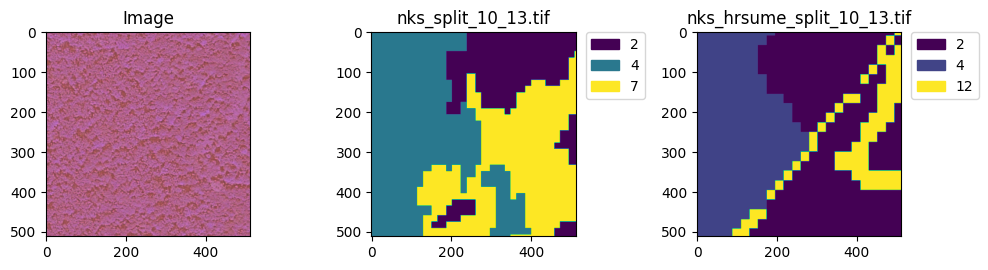

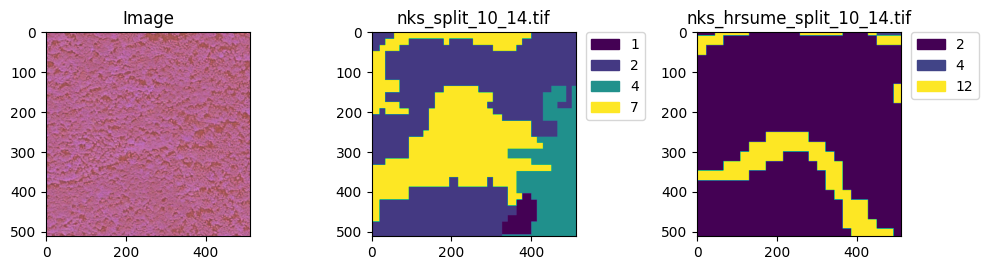

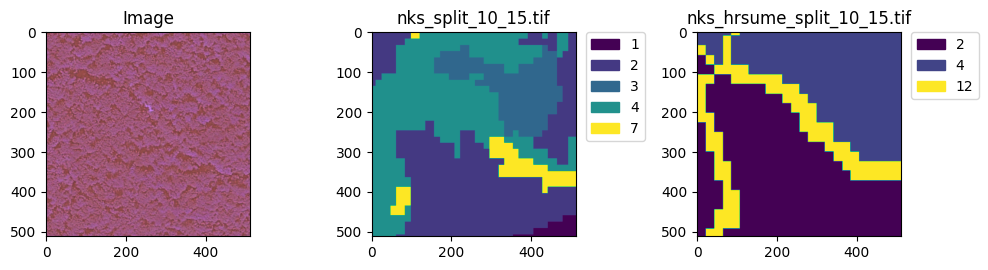

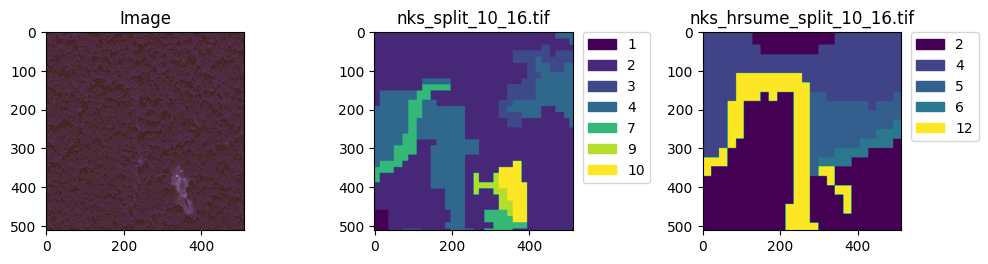

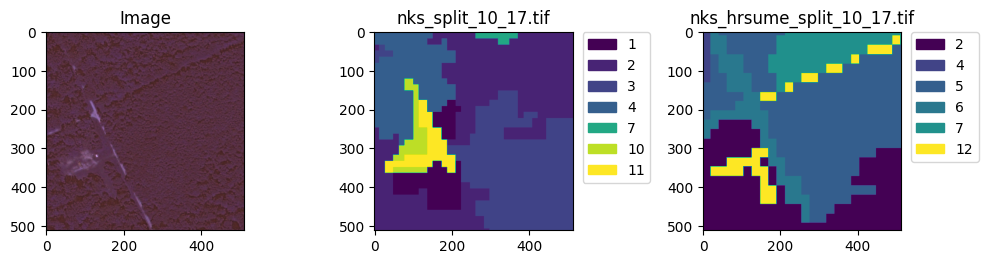

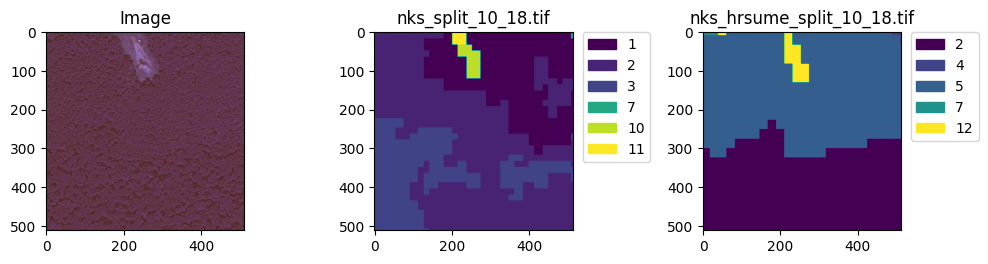

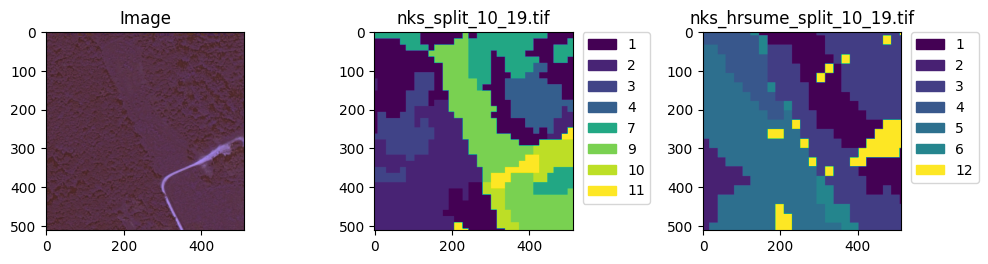

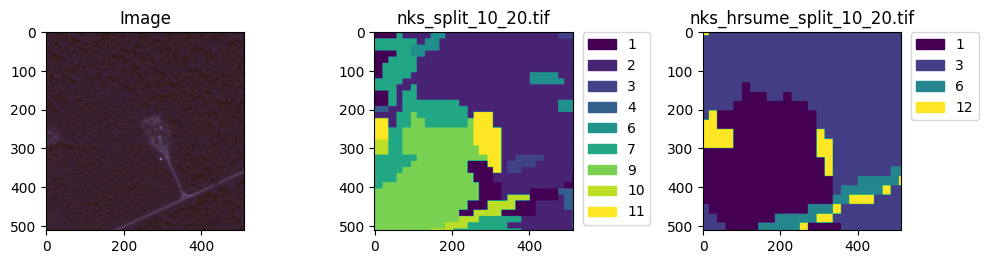

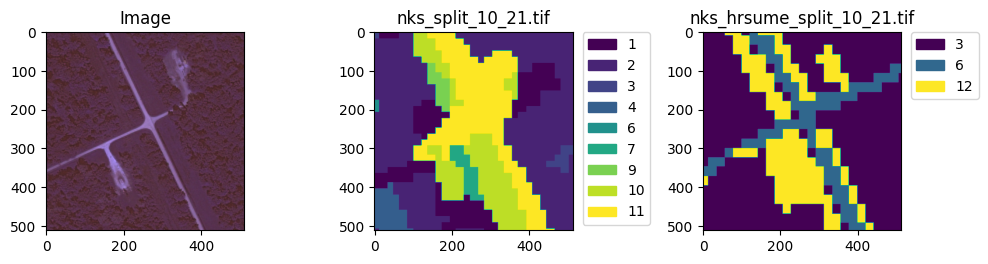

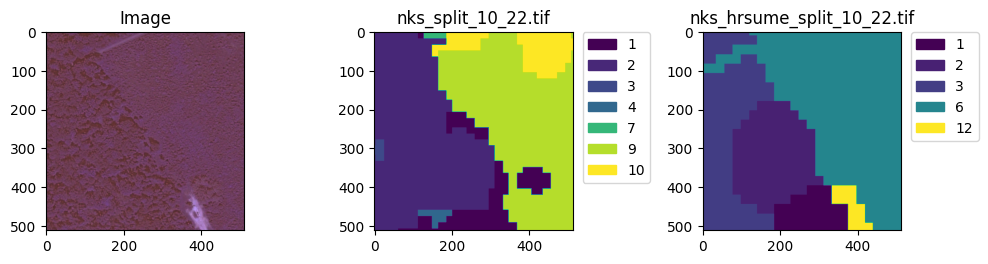

In [ ]:
import os

shown_so_far = 0
for i in range(5, len(nks_dataset)):
    if shown_so_far >= 10: break
    (nks_input, nks_target) = nks_dataset[i]
    (hrsume_input, hrsume_target) = nks_hrsume_dataset[i]
    nks_input = nks_input.numpy()[:3, :, :]
    hrsume_input = hrsume_input.numpy()[:3, :, :]
    nks_target = nks_target.numpy()
    hrsume_target = hrsume_target.numpy()
    if (hrsume_target == 12).sum() > 0:
        nks_input = ((nks_input / np.max(nks_input)) * 255).astype('uint8')
        nks_input = np.transpose(nks_input, (1, 2, 0))
        show_orig_and_masks(nks_input,
                            nks_target,
                            hrsume_target,
                            os.path.basename(nks_dataset.maskPaths[i]),
                            os.path.basename(nks_hrsume_dataset.maskPaths[i]))
        shown_so_far += 1

In [ ]:
x = np.array([[1,2],[3,4]])
print(x.sum())

10


### Plotting confusion matrix

In [ ]:
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=1, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

ground_truth = np.array([], dtype=np.int32)
predicted = np.array([], dtype=np.int32)
unet.eval()
with torch.no_grad():
  for (i, (input, target)) in enumerate(testLoader):
      (input, target) = (input.to(DEVICE), target.to(DEVICE))
      # make the predictions and calculate the validation loss
      pred = unet(input)
      pred = pred[0]
      pred_class = pred.softmax(dim=0).argmax(dim=0)

      ground_truth = np.concatenate([ground_truth, target[0].flatten().cpu().numpy()])
      predicted = np.concatenate([predicted, pred_class.flatten().cpu().numpy()])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


In [ ]:
cf_matrix = confusion_matrix(ground_truth, predicted, labels=np.arange(0,15))
print(f"predicted counts: {np.unique(predicted, return_counts=True)}")
print(f"ground_truth counts: {np.unique(ground_truth, return_counts=True)}")

predicted counts: (array([ 0,  2,  4,  6,  7, 12]), array([  631855,  4042316, 33067354,    14248,   511850,     5401]))
ground_truth counts: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12]), array([ 1590184,  2661904,  8944524,   841695, 10422413,  3331794,
        3431789,  4301998,   425821,   330784,   219635,  1770483]))


predicted counts: (array([ 0,  2,  4,  6,  7, 12]), array([  631855,  4042316, 33067354,    14248,   511850,     5401]))
ground_truth counts: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12]), array([ 1590184,  2661904,  8944524,   841695, 10422413,  3331794,
        3431789,  4301998,   425821,   330784,   219635,  1770483]))


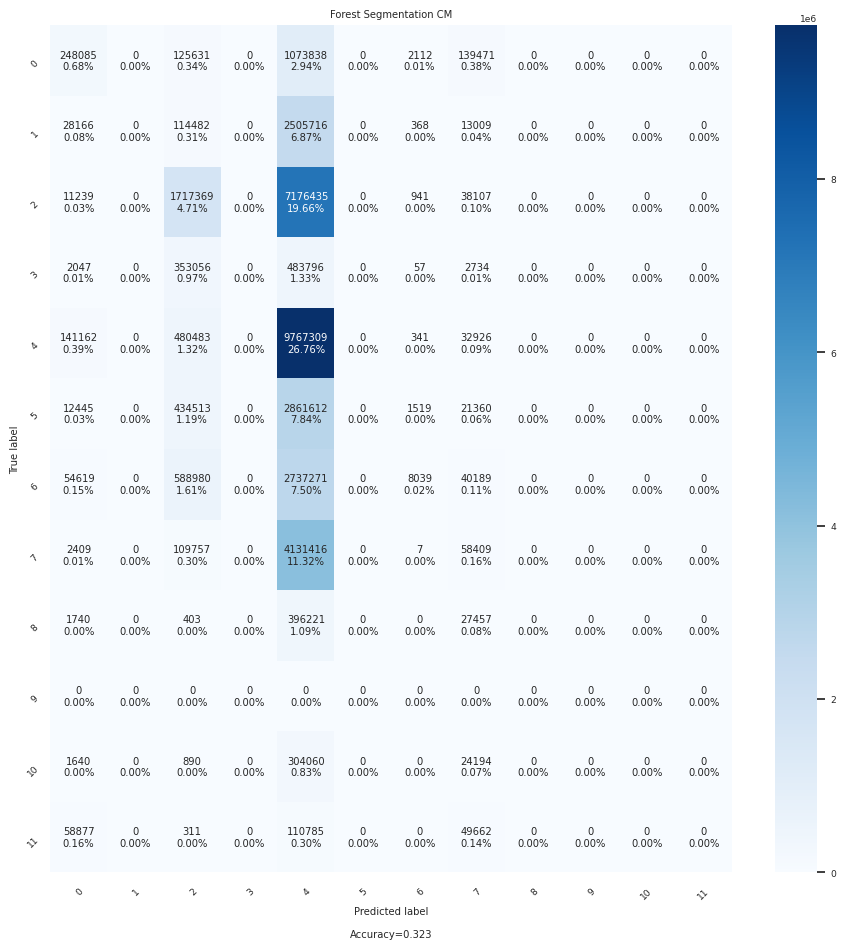

In [ ]:
cf_matrix = confusion_matrix(ground_truth, predicted, labels=np.arange(0,12))
print(f"predicted counts: {np.unique(predicted, return_counts=True)}")
print(f"ground_truth counts: {np.unique(ground_truth, return_counts=True)}")

sns.set(font_scale=0.6)
make_confusion_matrix(cf_matrix,
                      group_names=None,
                      count=True,
                      percent=True,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=True,
                      figsize=(11,11),
                      cmap='Blues',
                      title='Forest Segmentation CM')

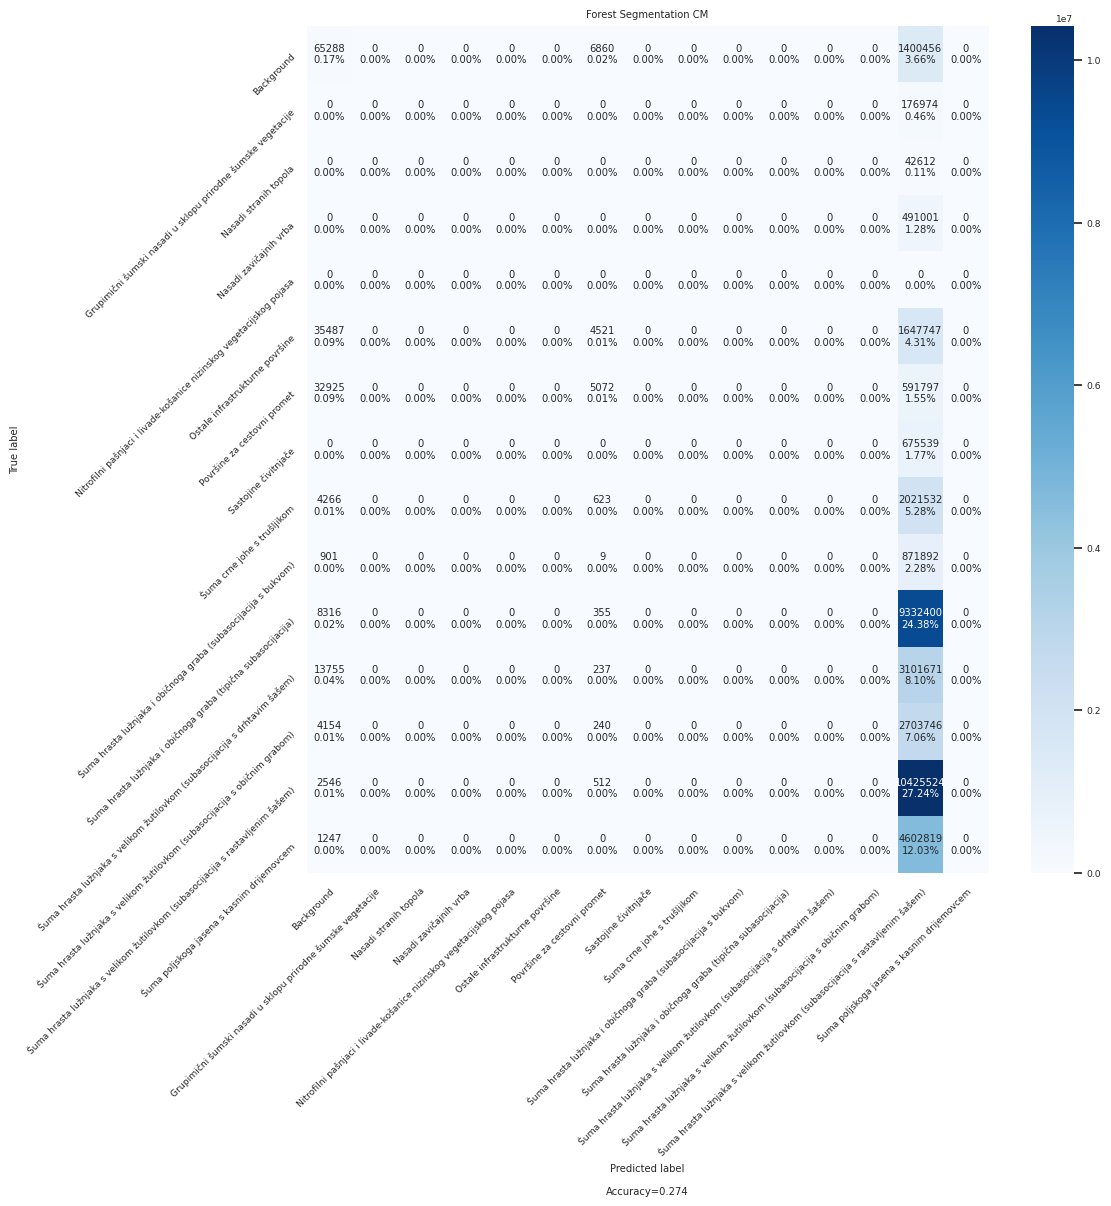

In [ ]:
sns.set(font_scale=0.6)
categories = ['Background',
              'Grupimični šumski nasadi u sklopu prirodne šumske vegetacije',
              'Nasadi stranih topola',
              'Nasadi zavičajnih vrba',
              'Nitrofilni pašnjaci i livade-košanice nizinskog vegetacijskog pojasa',
              'Ostale infrastrukturne površine',
              'Površine za cestovni promet',
              'Sastojine čivitnjače',
              'Šuma crne johe s trušljikom',
              'Šuma hrasta lužnjaka i običnoga graba (subasocijacija s bukvom)',
              'Šuma hrasta lužnjaka i običnoga graba (tipična subasocijacija)',
              'Šuma hrasta lužnjaka s velikom žutilovkom (subasocijacija s drhtavim šašem)',
              'Šuma hrasta lužnjaka s velikom žutilovkom (subasocijacija s običnim grabom)',
              'Šuma hrasta lužnjaka s velikom žutilovkom (subasocijacija s rastavljenim šašem)',
              'Šuma poljskoga jasena s kasnim drijemovcem']
make_confusion_matrix(cf_matrix,
                      group_names=None,
                      categories=categories,
                      count=True,
                      percent=True,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=True,
                      figsize=(11,11),
                      cmap='Blues',
                      title='Forest Segmentation CM')

In [ ]:
print(pred_class.shape)
print(pred_class[0])
for i in pred_class:
  print(i.shape)

torch.Size([1, 512, 512])
tensor([[13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        ...,
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13]], device='cuda:0')
torch.Size([512, 512])


In [ ]:
def prepare_plot(origImage, origMask, predMask, rawMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    pos1 = ax[0].imshow(origImage)
    pos2 = ax[1].imshow(origMask)
    figure.colorbar(pos2, ax=ax[1], shrink=0.15)
    pos3 = ax[2].imshow(predMask)
    figure.colorbar(pos3, ax=ax[2], shrink=0.15)
    pos4 = ax[3].imshow(rawMask)
    figure.colorbar(pos4, ax=ax[3], shrink=0.15)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    ax[3].set_title("Pred Mask Raw values")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

def make_predictions(model, mask, image):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        orig = image.copy()
        orig = (orig/60) * 255
        orig[orig < 0] = 0
        orig[orig > 255] = 255
        orig = np.uint8(orig)

        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH))
        #orig = image.copy()
        #orig = cv2.resize(orig, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH))
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = mask
        gtMask = np.uint8(np.isin(gtMask, [1,2,3,7,8,9,10,11,12,13,14]))
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMasksig = torch.sigmoid(predMask)
        predMasksig = predMasksig.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMasksig = predMasksig > 0.5
        #predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMasksig, predMask.cpu().numpy())

[INFO] load up model...
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_21_29.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_11_18.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_18_30.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_13_18.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_19_18.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_11_24.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_16_22.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_33_29.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_17_16.tif
drive/My Drive/Colab Notebooks/Dipl_Projekt/ForestDataset/wv2_0/wv2_0_split_22_28.tif


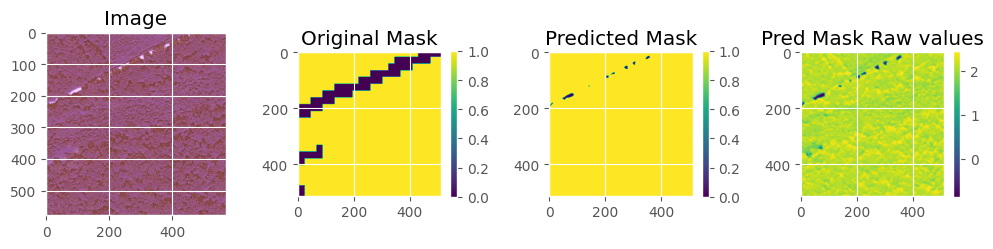

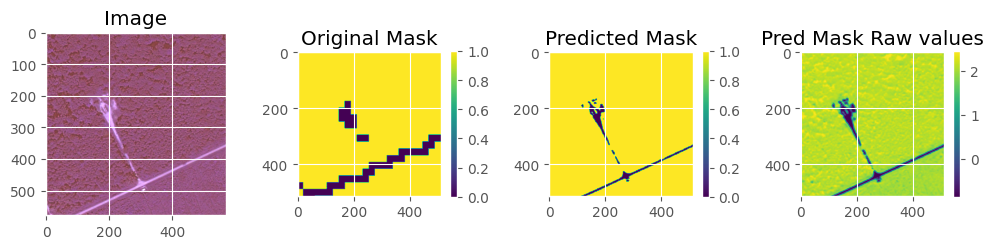

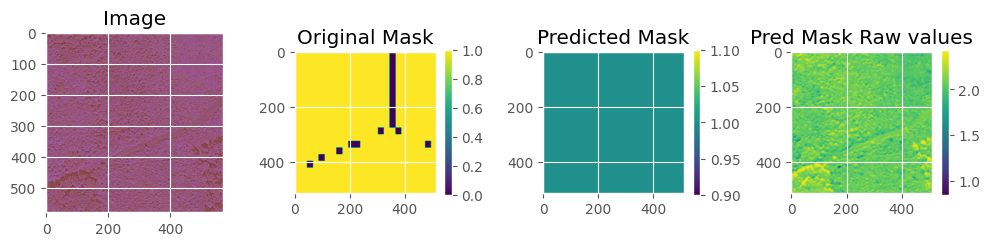

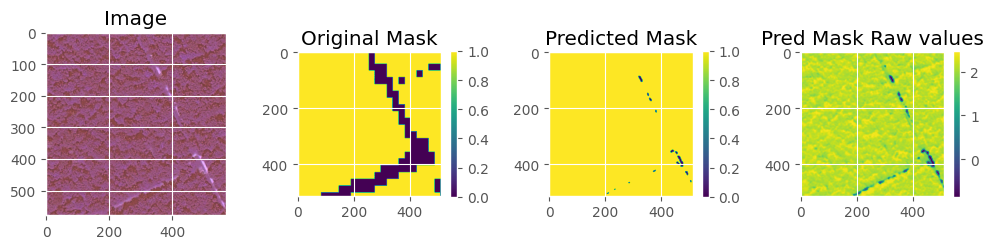

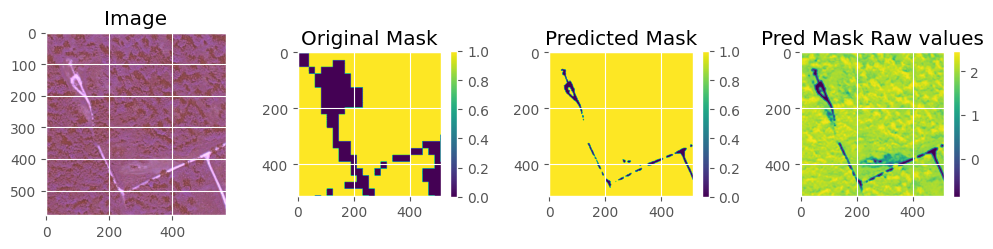

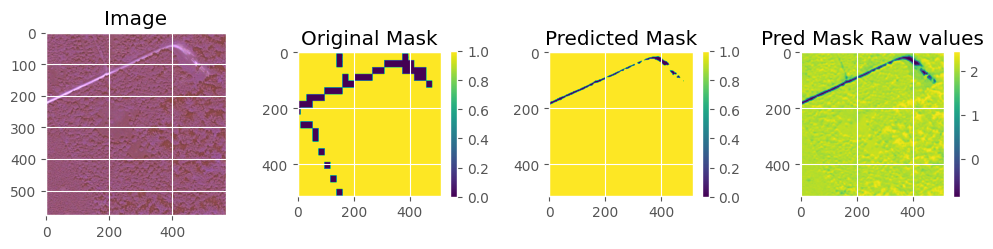

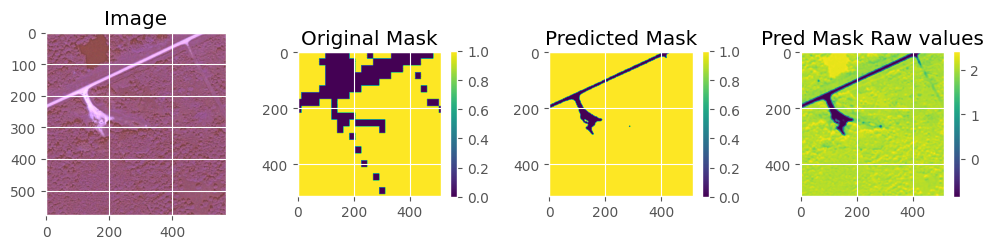

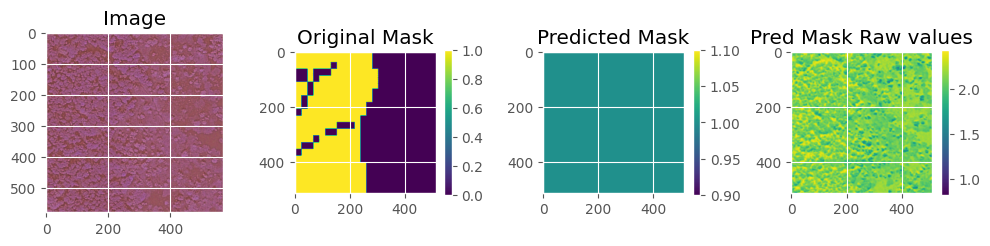

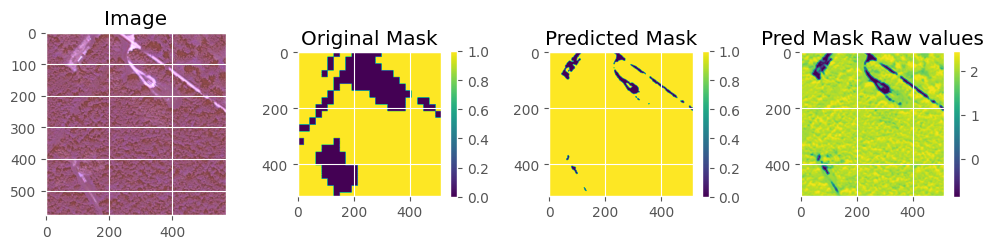

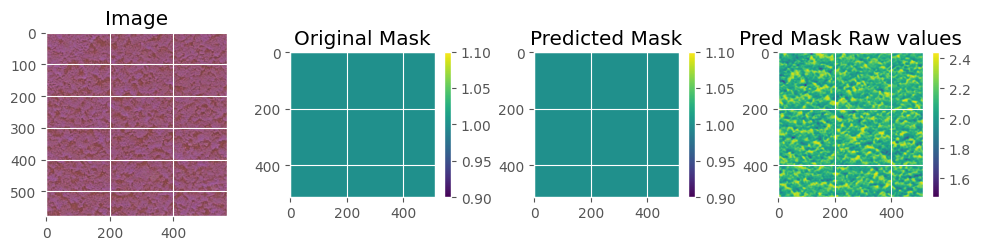

In [ ]:
# load the image paths in our testing file and randomly select 2
# image paths
# print("[INFO] loading up test image paths...")
# imagePaths = open(TEST_PATHS).read().strip().split("\n")
# imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
#unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
# with torch.no_grad():
#   unet.head.bias+=6
indexes = random.sample(range(len(testImages0)), 10)


for i in indexes:
    image0Path = testImages0[i]
    image1Path = testImages1[i]
    image2Path = testImages2[i]
    print(image0Path)
    # load the image from disk
    # and read the associated mask from disk
    image0 = cv2.imread(image0Path, cv2.IMREAD_UNCHANGED)
    image1 = cv2.imread(image1Path, cv2.IMREAD_UNCHANGED)
    image2 = cv2.imread(image2Path, cv2.IMREAD_UNCHANGED)
    image = np.dstack([image0, image1, image2])

    mask = cv2.imread(testMasks[i], cv2.IMREAD_UNCHANGED)
    mask = np.float32(np.isin(mask, [8,9,10,11,12,13,14]))

    # make predictions and visualize the results
    make_predictions(unet, mask, image)

Suspicious mask: drive/My Drive/Colab Notebooks/Dipl_Projekt/One_Channel_ForestDataset/wv2_0/wv2_0_split_39_33.tif